# TRADE

In [1]:
import numpy as np
import pandas as pd
import sqlite3

import plotnine as p9
from mizani.breaks import date_breaks
from mizani.formatters import date_format, dollar_format

from ipynb.fs.defs.market_4_rank import (
    get_cagr_histories,
    get_quantile_histories,
    get_tail,
    get_rank_histories)

### GET PRICE, CAGR, AND RANK HISTORIES

In [2]:
con = sqlite3.connect('market.db')

price_histories = (
    pd.read_sql('SELECT * FROM sp5_close_histories', con, parse_dates=['Date'])
    .pivot(index='Date', columns='Symbol', values='Close'))

# display(close_histories)

In [3]:
cagr_days = 63
q_days = 252
q = 0.75
tail_days = 2*252

cagr_histories = get_cagr_histories(price_histories, cagr_days)
quantile_histories = get_quantile_histories(cagr_histories, q_days, q)
quantile_histories = get_tail(quantile_histories, tail_days)
rank_histories = get_rank_histories(quantile_histories)

# display(cagr_histories)
# display(quantile_histories)
# display(rank_histories)

In [4]:
rank_histories

Symbol,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-15,234,470,469,16,60,314,482,329,197,115,...,360,270,484,194,432,253,163,67,388,98
2020-05-18,234,470,469,16,60,313,481,329,204,114,...,358,279,484,200,432,252,162,67,387,98
2020-05-19,234,471,469,16,59,312,480,328,208,115,...,357,284,484,202,431,252,161,67,387,97
2020-05-20,234,471,469,16,59,311,478,328,217,114,...,357,283,485,203,431,252,161,67,386,98
2020-05-21,232,470,471,16,59,313,478,328,217,114,...,356,283,485,210,431,251,161,67,386,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-09,115,468,191,126,32,141,362,386,149,59,...,490,342,52,485,155,274,463,301,185,73
2022-05-10,115,468,190,126,32,138,360,384,142,59,...,490,341,52,485,159,271,463,305,188,72
2022-05-11,114,468,190,125,32,136,360,384,140,59,...,490,339,51,485,158,268,464,304,189,72


### TRADE

In [5]:
def trade(price_histories, rank_histories, rank_keep=20, num_hold=10, cash= 5_000):

    positions = pd.Series(dtype='float64')
    balance_history = pd.Series(dtype='float64')
    transaction_history = pd.DataFrame()

    for date, _ in rank_histories.iterrows():
        prices = price_histories.loc[date]  
        ranks = rank_histories.loc[date]

        logic1 = ranks > rank_keep
        num_sell = sum(logic1)
        if num_sell > 0:
            
            # GET SYMBOLS TO SELL
            logic2 = ranks.index.isin(positions.index)
            rank_sells = ranks[logic1 & logic2]
            symbol_sells = rank_sells.sort_values(ascending=False).index.to_list()

            # SELL
            for symbol in symbol_sells:
                transaction = {
                    'Date': date,
                    'Action': 'Sell',
                    'Qty': positions[symbol],
                    'Symbol': symbol,
                    'Price': prices[symbol],
                    'Change': +positions[symbol]*prices[symbol],
                    'Rank': ranks[symbol]}

                positions = positions.drop(symbol)
                cash += transaction['Change']
                transaction_history = pd.concat([transaction_history,
                    pd.DataFrame(transaction, index=[0])], ignore_index=True)

        num_buy = num_hold - len(positions)
        if num_buy > 0:
            cash_per = cash/num_buy

            # GET SYMBOLS TO BUY
            logic1 = prices <= cash_per
            logic2 = ranks.index.isin(prices[logic1].index)
            logic3 = ranks.index.isin(positions.index)
            rank_buys = ranks[logic2 & ~logic3].nsmallest(num_buy)
            symbol_buys = rank_buys.index.to_list()

            # BUY
            for symbol in symbol_buys:
                transaction = {
                    'Date': date,
                    'Action': 'Buy',
                    'Qty': int(cash_per/prices[symbol]),
                    'Symbol': symbol,
                    'Price': prices[symbol],
                    'Change': -int(cash_per/prices[symbol])*prices[symbol],
                    'Rank': ranks[symbol]}

                positions[symbol] = transaction['Qty']
                cash += transaction['Change']
                transaction_history = pd.concat([transaction_history,
                    pd.DataFrame(transaction, index=[0])], ignore_index=True)

        balance = cash + (positions*prices).sum()
        balance_history[date] = balance
        

    # AT THHE END, ADD SYMBOLS THAT ARE OWNED
    logic = ranks.index.isin(positions.index)
    ranks_own = ranks[logic].sort_values()
    symbols_own = ranks_own.index.to_list()
    
    # ADD OWNED
    for symbol in symbols_own:
        transaction = {
            'Date': date,
            'Action': 'Owned',
            'Qty': positions[symbol],
            'Symbol': symbol,
            'Price': prices[symbol],
            'Change': +positions[symbol]*prices[symbol],
            'Rank': ranks[symbol]}

        transaction_history = pd.concat([transaction_history,
            pd.DataFrame(transaction, index=[0])], ignore_index=True)

    return balance_history.rename('Balance').rename_axis('Date'), transaction_history

In [6]:
balance_history, transaction_history = trade(price_histories, rank_histories)

display(balance_history)
display(transaction_history)

Date
2020-05-15     5000.000000
2020-05-18     5356.368145
2020-05-19     5339.523912
2020-05-20     5446.535061
2020-05-21     5372.075588
                  ...     
2022-05-09    17450.026988
2022-05-10    17717.776793
2022-05-11    17704.536698
2022-05-12    17739.396607
2022-05-13    18872.376678
Name: Balance, Length: 504, dtype: float64

,Date,Action,Qty,Symbol,Price,Change,Rank
0,2020-05-15,Buy,8,ENPH,58.380001,-467.040009,1
1,2020-05-15,Buy,3,TSLA,159.834000,-479.501999,2
2,2020-05-15,Buy,4,SEDG,120.440002,-481.760010,3
3,2020-05-15,Buy,1,DXCM,417.730011,-417.730011,4
4,2020-05-15,Buy,7,MRNA,66.690002,-466.830017,5
5,2020-05-15,Buy,7,ETN,71.267197,-498.870377,6
6,2020-05-15,Buy,9,AMD,54.200001,-487.800007,7
7,2020-05-15,Buy,4,GNRC,104.699997,-418.799988,9
8,2020-05-15,Buy,5,QRVO,94.709999,-473.549995,10
9,2020-05-15,Buy,21,CZR,23.209999,-487.409981,11


In [7]:
display(transaction_history
    .sort_values(['Symbol', 'Date'])
    .set_index(['Symbol', 'Date']))

Action  Qty       Price       Change  Rank
Symbol Date                                                 
ALGN   2020-07-14    Buy    2  299.619995  -599.239990     7
       2021-08-16   Sell    2  690.750000  1381.500000    23
AMD    2020-05-15    Buy    9   54.200001  -487.800007     7
       2020-07-24   Sell    9   69.400002   624.600014    21
       2022-03-15    Buy   11  109.330002 -1202.630020     9
       2022-05-13  Owned   11   95.120003  1046.320030     9
APA    2022-01-10    Buy   68   29.223789 -1987.217667     6
       2022-05-13  Owned   68   41.150002  2798.200104     2
BBWI   2020-11-25    Buy   25   31.163080  -779.077005     5
       2022-03-08   Sell   25   45.590000  1139.750004    22
CZR    2020-05-15    Buy   21   23.209999  -487.409981    11
       2021-03-23   Sell   21   84.589996  1776.389923    21
DVN    2021-12-29    Buy   34   44.200001 -1502.800026     4
       2022-05-13  Owned   34   68.699997  2335.799896     5
DXCM   2020-05-15    Buy    1  417.730011  -417.730011     4
       2021-01-11   Sell    1  370.640015   370.640015    21
ENPH   2020-05-15    Buy    8   58.380001  -467.040009     1
       2021-12-29   Sell    8  185.470001  1483.760010    22
ETN    2020-05-15    Buy    7   71.267197  -498.870377     6
       2020-08-24   Sell    7  100.183640   701.285477    25
ETSY   2020-08-24    Buy    5  128.740005  -643.700027     6
       2021-08-25   Sell    5  202.279999  1011.399994    26
F      2022-01-13    Buy   24   24.727501  -593.460022     7
       2022-04-11   Sell   24   15.179008   364.296204    21
FANG   2021-08-25    Buy   13   75.010002  -975.130028     8
       2022-05-13  Owned   13  133.429993  1734.589905    15
FCX    2021-01-11    Buy   13   30.075827  -390.985746     7
       2022-01-13   Sell   13   44.330002   576.290024    23
FTNT   2022-02-17    Buy    8  310.540009 -2484.320068     7
       2022-05-13  Owned    8  281.549988  2252.399902    13
GNRC   2020-05-15    Buy    4  104.699997  -418.799988     9
       2020-07-14   Sell    4  131.130005   524.520020    21
IT     2022-04-11    Buy    1  288.790009  -288.790009     9
       2022-05-13  Owned    1  255.520004   255.520004    11
MRNA   2020-05-15    Buy    7   66.690002  -466.830017     5
       2022-05-13  Owned    7  137.910004   965.370026     1
MRO    2021-03-23    Buy  177   10.024014 -1774.250562     5
       2022-05-13  Owned  177   27.000000  4779.000000     4
NUE    2022-03-08    Buy   11  125.541527 -1380.956795     8
       2022-05-13  Owned   11  123.790001  1361.690010    17
NVDA   2022-01-19    Buy    7  250.627304 -1754.391129     8
       2022-05-13  Owned    7  177.059998  1239.419983     3
OXY    2021-08-16    Buy   62   24.713015 -1532.206905     7
       2022-01-10   Sell   62   32.302906  2002.780174    21
PENN   2020-07-24    Buy   25   34.779999  -869.499969     9
       2021-10-15   Sell   25   77.699997  1942.499924    24
QRVO   2020-05-15    Buy    5   94.709999  -473.549995    10
       2020-11-25   Sell    5  148.240005   741.200027    21
SBNY   2021-08-10    Buy    4  254.490005 -1017.960022     5
       2022-03-15   Sell    4  294.959991  1179.839966    21
SEDG   2020-05-15    Buy    4  120.440002  -481.760010     3
       2021-08-10   Sell    4  296.399994  1185.599976    21
TPR    2021-10-15    Buy   51   38.712467 -1974.335827     7
       2022-01-19   Sell   51   37.233517  1898.909351    21
TSLA   2020-05-15    Buy    3  159.834000  -479.501999     2
       2022-02-17   Sell    3  876.349976  2629.049927    21

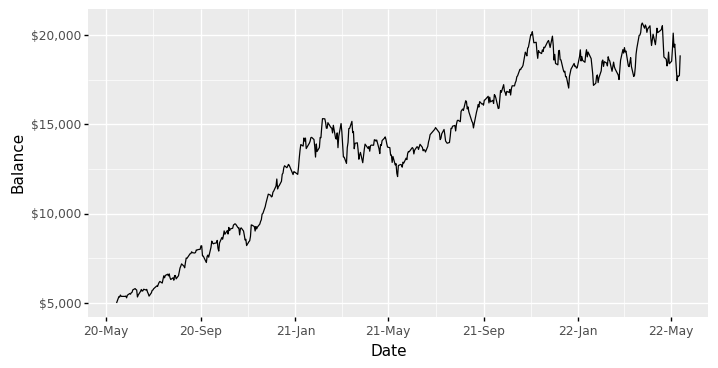

<ggplot: (8770791472219)>

In [8]:
df = balance_history.reset_index()

p = (p9.ggplot(data=df, mapping=p9.aes(x='Date', y='Balance'))
    + p9.theme(figure_size=(8, 4))
    + p9.scale_x_datetime(breaks=date_breaks('4 months'), labels=date_format('%y-%b'))
    + p9.geom_line()
    + p9.scale_y_continuous(labels=dollar_format(prefix='$', digits=0, big_mark=',')))

display(p)